In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [47]:
df = pd.read_csv('data/clean_nonull.csv')

df = pd.concat([
    df.drop(columns=['VKORC1_SNP']),
    pd.get_dummies(df['VKORC1_SNP'], prefix='VKORC1_SNP')
], axis=1)

df['label'] = df['correct_dosage'].map({'low': 0, 'medium': 1, 'high': 2})

In [84]:
df.groupby('correct_dosage').label.count()

correct_dosage
high       534
low       1151
medium    2701
Name: label, dtype: int64

## UCB1

In [115]:
np.random.seed(1)

B = 20

perfs = []
for b in tqdm(range(B)):
    order = np.random.choice(range(df.shape[0]), size=df.shape[0], replace=False)
    X = df.drop(columns=['correct_dosage', 'label']).iloc[order, :].values
    y = df['label'].values[order]

    chosen_arms = [0] # always sample arm 0 first
    rewards = [0 if y[0] == chosen_arms[0] else -1]

    delta = 3 / X.shape[0]  # for fixed number of time steps, set delta = |A|/T (lecture 10, slide 49)

    for i in range(1, X.shape[0]):

        # sample the other two arms, to initialize UCB
        if i == 1:
            pred_a = 1
        elif i == 2:
            pred_a = 2
        else:
            cumul_data = X[:i, :].copy()  # get all of the past data

            # add indicators for which of the previous arms was chosen
            arm_features = np.zeros((cumul_data.shape[0], 3))

            for j, a in enumerate(chosen_arms):
                arm_features[j, a] = 1

            # concatenate these arm features to our feature vector
            X_tmp = np.hstack([cumul_data, arm_features])

            # learn the parameters
            theta = np.linalg.pinv(X_tmp) @ np.array(rewards)

            # candidate_vectors
            x_cands = np.stack([
                np.hstack([X[i], np.array([1, 0, 0])]),
                np.hstack([X[i], np.array([0, 1, 0])]),
                np.hstack([X[i], np.array([0, 0, 1])])
            ])

            chosen_arr = np.array(chosen_arms)

            ucb_bonus = np.array([
                np.sqrt(2 * np.log(1/delta) / chosen_arr[chosen_arr == a].shape[0])
                for a in range(3)
            ])

            pred_a = (x_cands @ theta + ucb_bonus).argmax()

        chosen_arms.append(int(pred_a))
        rewards.append(0 if y[i] == int(pred_a) else -1)
    
    perf = pd.DataFrame({
        "run": b,
        "predicted_arm": chosen_arms,
        "observed_reward": rewards,
        "true_arm": y,
    })

    perf['cumulative_accuracy'] = (
        perf['predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_fixed_baseline_accuracy'] = (
        perf['true_arm'] == 1
    ).cumsum() / (perf.index + 1)

    perf['cumulative_regret'] = -1 * perf['observed_reward'].cumsum()

    perf['cumulative_fixed_baseline_regret'] = -1 * np.where(
        perf['true_arm'] == 1,
        0,
        -1
    ).cumsum()
    
    perfs.append(perf)

ucb1_performances = pd.concat(perfs)
ucb1_performances['t'] = ucb1_performances.index

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:09<00:00, 15.49s/it]


In [132]:
ucb1_grouped = grouped.copy()

<AxesSubplot:xlabel='t'>

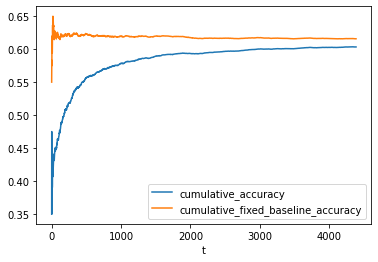

In [124]:
ucb1_grouped = ucb1_performances.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret'
]].mean()    

ucb1_grouped[[
    'cumulative_accuracy',
    'cumulative_fixed_baseline_accuracy'
]].plot()

<AxesSubplot:xlabel='t'>

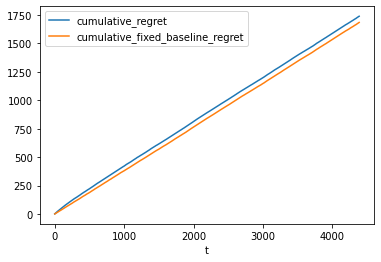

In [125]:
ucb1_grouped[[
    'cumulative_regret',
    'cumulative_fixed_baseline_regret'
]].plot()

## decaying $\epsilon$-greedy

In [129]:
start_eps = 0.2
end_eps = 1

step_size = (end_eps - start_eps) / X.shape[0]

eps_vals = [start_eps + i * step_size for i in range(X.shape[0])]

In [131]:
np.random.seed(1)

B = 20

perfs = []
for b in tqdm(range(B)):
    order = np.random.choice(range(df.shape[0]), size=df.shape[0], replace=False)
    X = df.drop(columns=['correct_dosage', 'label']).iloc[order, :].values
    y = df['label'].values[order]

    chosen_arms = [np.random.randint(3)] # start with a random sample
    rewards = [0 if y[0] == chosen_arms[0] else -1]

    for i in range(1, X.shape[0]):
        cumul_data = X[:i, :].copy()  # get all of the past data

        # add indicators for which of the previous arms was chosen
        arm_features = np.zeros((cumul_data.shape[0], 3))

        for j, a in enumerate(chosen_arms):
            arm_features[j, a] = 1

        # concatenate these arm features to our feature vector
        X_tmp = np.hstack([cumul_data, arm_features])

        # learn the parameters
        theta = np.linalg.pinv(X_tmp) @ np.array(rewards)

        # candidate_vectors
        x_cands = np.stack([
            np.hstack([X[i], np.array([1, 0, 0])]),
            np.hstack([X[i], np.array([0, 1, 0])]),
            np.hstack([X[i], np.array([0, 0, 1])])
        ])

        chosen_arr = np.array(chosen_arms)

        max_a = (x_cands @ theta).argmax()
        
        # choose the argmax w prob e, random w prob 1-e
        pred_a = max_a if np.random.uniform(0,1) < eps_vals[i] else np.random.randint(3)

        chosen_arms.append(int(pred_a))
        rewards.append(0 if y[i] == int(pred_a) else -1)
    
    perf = pd.DataFrame({
        "run": b,
        "predicted_arm": chosen_arms,
        "observed_reward": rewards,
        "true_arm": y,
    })

    perf['cumulative_accuracy'] = (
        perf['predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_fixed_baseline_accuracy'] = (
        perf['true_arm'] == 1
    ).cumsum() / (perf.index + 1)

    perf['cumulative_regret'] = -1 * perf['observed_reward'].cumsum()

    perf['cumulative_fixed_baseline_regret'] = -1 * np.where(
        perf['true_arm'] == 1,
        0,
        -1
    ).cumsum()
    
    perfs.append(perf)

egreedy_performances = pd.concat(perfs)
egreedy_performances['t'] = egreedy_performances.index

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:01<00:00, 15.08s/it]


<AxesSubplot:xlabel='t'>

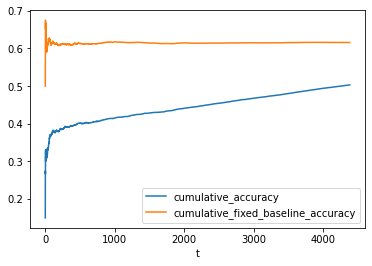

In [133]:
egreedy_grouped = egreedy_performances.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret'
]].mean()    

egreedy_grouped[[
    'cumulative_accuracy',
    'cumulative_fixed_baseline_accuracy'
]].plot()

<AxesSubplot:xlabel='t'>

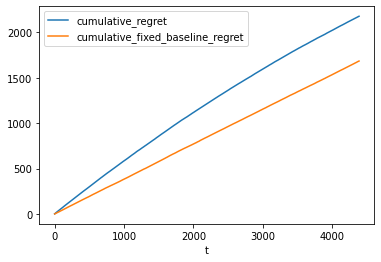

In [134]:
egreedy_grouped[[
    'cumulative_regret',
    'cumulative_fixed_baseline_regret'
]].plot()

## try UCB with disjoint $\theta$

### this is not really working yet, needs more thought...

In [146]:
np.random.seed(1)

B = 1

perfs = []
for b in range(B):
    order = np.random.choice(range(df.shape[0]), size=df.shape[0], replace=False)
    X = df.drop(columns=['correct_dosage', 'label']).iloc[order, :].values
    y = df['label'].values[order]

    chosen_arms = [0] # always sample arm 0 first
    rewards = [0 if y[0] == chosen_arms[0] else -1]

    delta = 3 / X.shape[0]  # for fixed number of time steps, set delta = |A|/T (lecture 10, slide 49)

    for i in tqdm(range(1, X.shape[0])):

        # sample the other two arms, to initialize UCB
        if i == 1:
            pred_a = 1
        elif i == 2:
            pred_a = 2
        else:
            cumul_data = X[:i, :].copy()  # get all of the past data

            # add indicators for which of the previous arms was chosen
            arm_features = np.zeros((cumul_data.shape[0], 3))

            for j, a in enumerate(chosen_arms):
                arm_features[j, a] = 1

            # concatenate these arm features to our feature vector
            X_tmp = np.hstack([cumul_data, arm_features])

            # learn the parameters
            thetas = []
            for a in range(3):
                past_run_idxs = [k for k in chosen_arms if k == a]
                sub_x = cumul_data[past_run_idxs]
                sub_y = np.array(rewards)[past_run_idxs]
                
                thetas.append(np.linalg.pinv(sub_x) @ np.array(sub_y))
                

            # candidate_vectors
            x_cands = np.repeat(np.expand_dims(X[i], axis=0), repeats=3, axis=0)

            vals = np.diag(x_cands @ np.stack(thetas).T)
            
            chosen_arr = np.array(chosen_arms)

            ucb_bonus = np.array([
                np.sqrt(2 * np.log(1/delta) / chosen_arr[chosen_arr == a].shape[0])
                for a in range(3)
            ])

            pred_a = (vals + ucb_bonus).argmax()

        chosen_arms.append(int(pred_a))
        rewards.append(0 if y[i] == int(pred_a) else -1)
    
    perf = pd.DataFrame({
        "run": b,
        "predicted_arm": chosen_arms,
        "observed_reward": rewards,
        "true_arm": y,
    })

    perf['cumulative_accuracy'] = (
        perf['predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_fixed_baseline_accuracy'] = (
        perf['true_arm'] == 1
    ).cumsum() / (perf.index + 1)

    perf['cumulative_regret'] = -1 * perf['observed_reward'].cumsum()

    perf['cumulative_fixed_baseline_regret'] = -1 * np.where(
        perf['true_arm'] == 1,
        0,
        -1
    ).cumsum()
    
    perfs.append(perf)

ucb1_performances = pd.concat(perfs)
ucb1_performances['t'] = ucb1_performances.index

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4385/4385 [00:20<00:00, 211.40it/s]
